In [22]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [23]:
words = open('../names.txt', 'r').read().splitlines()

In [24]:
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [25]:
len(words)

32033

In [26]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

In [27]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [28]:
Xtr.shape, Ytr.shape # dataset

(torch.Size([182625, 3]), torch.Size([182625]))

In [111]:
dimension_space = 15
context_dimension = dimension_space * block_size
hidden_layer_neurons = 300

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, dimension_space), generator=g)
W1 = torch.randn((context_dimension, hidden_layer_neurons), generator=g)
b1 = torch.randn(hidden_layer_neurons, generator=g)
W2 = torch.randn((hidden_layer_neurons, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [112]:
sum(p.nelement() for p in parameters) # number of parameters in total

22332

In [113]:
C.shape, W1.shape, b1.shape, W2.shape, b2.shape

(torch.Size([27, 15]),
 torch.Size([45, 300]),
 torch.Size([300]),
 torch.Size([300, 27]),
 torch.Size([27]))

In [114]:
for p in parameters:
  p.requires_grad = True

In [132]:
for i in range(200000):
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (64,))
  
  # forward pass
  emb = C[Xtr[ix]] # (32, 3, 2)
  h = torch.tanh(emb.view(-1, context_dimension) @ W1 + b1) # (32, 100)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Ytr[ix])
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i > 10000 else 0.05
  for p in parameters:
    p.data += -lr * p.grad
    
print(loss.item())

1.7931296825408936


In [133]:
#te loss
emb = C[Xte]
h = torch.tanh(emb.view(-1, context_dimension) @ W1 + b1) 
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Yte)
loss

tensor(2.1612, grad_fn=<NllLossBackward0>)

In [134]:
#dev loss
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, context_dimension) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1546, grad_fn=<NllLossBackward0>)

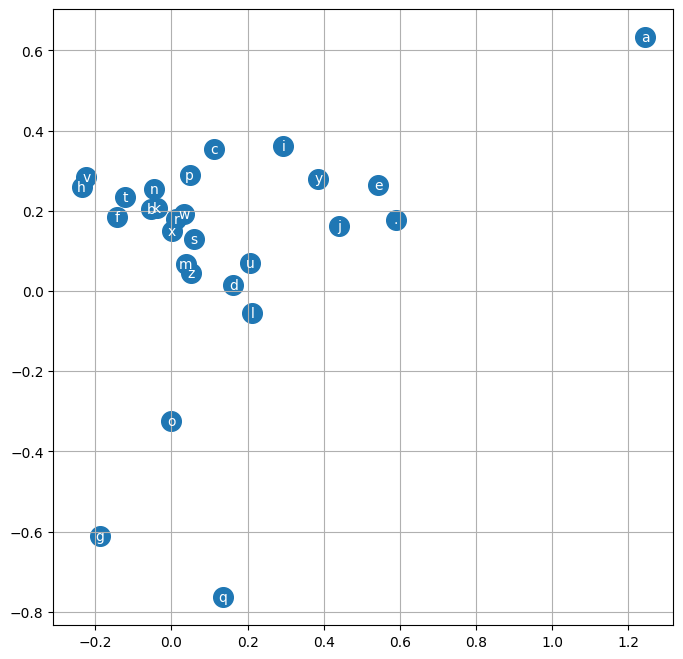

In [124]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [135]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

mora.
kayah.
see.
madhrith.
reisha.
endra.
gradeek.
melin.
shy.
jenne.
elisson.
arleiyah.
honel.
nosalder.
shirael.
kin.
renellennie.
cayus.
kavdariyah.
faeh.
